# Node representation learning with Deep Graph Infomax


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo demonstrates how to perform unsupervised training of several models using [the Deep Graph Infomax algorithm](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax) (https://arxiv.org/pdf/1809.10341.pdf) on the CORA dataset:

- [GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GCN) (both as a full-batch method, and with [the Cluster-GCN training procedure](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator))
- [GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) (only as a full-batch method, but the Cluster-GCN training procedure is also supported)
- [APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) (as with GAT, only as a full-batch method, but the Cluster-GCN training procedure is also supported)
- [RGCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.RGCN)
- [GraphSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GraphSAGE)
- [HinSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.HinSAGE)

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

> See [the GCN + Deep Graph Infomax fine-tuning demo](../node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb) for semi-supervised training using Deep Graph Infomax, by fine-tuning the base model for node classification using labelled data.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

## Data Generators

Now we create the data generators using `CorruptedGenerator` ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.CorruptedGenerator)). `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [5]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


## GCN Model Creation and Training

We create and train our `DeepGraphInfomax` model ([docs](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax)). Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [6]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [7]:
epochs = 100

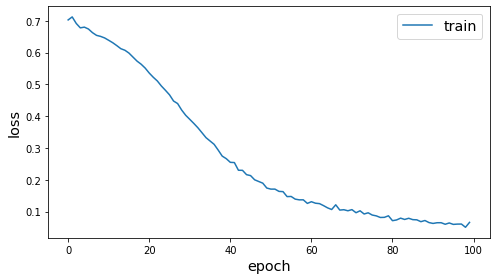

In [8]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

## Extracting Embeddings and Logistic Regression

Since we've already trained the weights of our base model - GCN in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. Then we use logistic regression on the node embeddings to predict which class the node belongs to.

Note that the results here differ from the paper due to different train/test/val splits.

In [9]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [10]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = fullbatch_generator.flow(test_subjects.index)
train_gen = fullbatch_generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_subjects).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.7854799015586547


In [33]:
train_subjects.shape

(270,)

In [34]:
node_subjects

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object

In [39]:
train_embeddings[0].shape

(128,)

In [31]:
train_subjects

1107355    Reinforcement_Learning
1152910    Reinforcement_Learning
645897      Probabilistic_Methods
308003              Rule_Learning
633081      Probabilistic_Methods
                    ...          
1118347           Neural_Networks
1108841           Neural_Networks
96845          Genetic_Algorithms
182094         Genetic_Algorithms
595193         Genetic_Algorithms
Name: subject, Length: 270, dtype: object

In [12]:
test_subjects

1127530     Probabilistic_Methods
118079     Reinforcement_Learning
1116397                Case_Based
616336              Rule_Learning
13213      Reinforcement_Learning
                    ...          
75691             Neural_Networks
1128425           Neural_Networks
286562            Neural_Networks
110163                 Case_Based
11335               Rule_Learning
Name: subject, Length: 2438, dtype: object

This accuracy is close to that for [training a supervised GCN model end-to-end](../node-classification/gcn-node-classification.ipynb), suggesting that Deep Graph Infomax is an effective method for unsupervised training.

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [13]:
all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

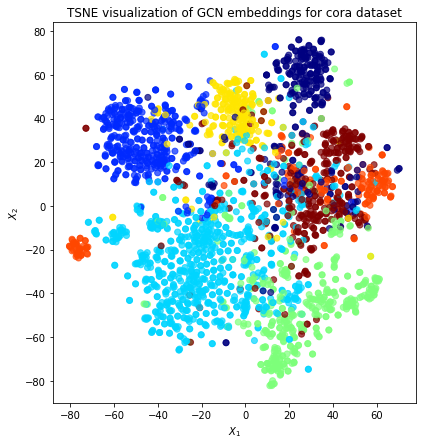

In [14]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for cora dataset")
plt.show()

## Comparing Different Models

Now we run Deep Graph Infomax training for other models. Note that switching between StellarGraph models only requires a few code changes.

In [15]:
def run_deep_graph_infomax(
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    ordered_test_subjects = reorder(test_gen, test_subjects)
    ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc

### Cluster-GCN

[Cluster-GCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.ClusterNodeGenerator) is a scalable training procedure for that works for several "full batch" models in StellarGraph, including GCN, GAT and APPNP. This example just trains on GCN. The training mechanism breaks the graph into a number of small subgraph "clusters" and trains a single GCN model on these, successively. It is equivalent to full-batch GCN with a single cluster (`clusters=1`), but with `clusters > 1` random clusters (as used here), its performance will be less than GCN. With better clusters, Cluster-GCN performance should be much improved.

(Note: `ClusterNodeGenerator` can be [used with Neo4j](https://stellargraph.readthedocs.io/en/stable/demos/connector/neo4j/cluster-gcn-on-cora-neo4j-example.html) for scalable training on large graphs, including unsupervised via Deep Graph Infomax.)

In [16]:
cluster_generator = ClusterNodeGenerator(G, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")

Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233
Test classification accuracy: 0.6587366694011485


### GAT

[GAT](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GAT) is a "full batch" model similar to GCN. It can also be trained using both `FullBatchNodeGenerator` and `ClusterNodeGenerator`, including for Deep Graph Infomax.

In [17]:
gat_model = GAT(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator, attn_heads=8,
)
gat_acc = run_deep_graph_infomax(gat_model, fullbatch_generator, epochs=epochs)

gat_acc
print(f"Test classification accuracy: {gat_acc}")

Test classification accuracy: 0.42083675143560295


### APPNP

[APPNP](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.APPNP) is a "full batch" model similar to GCN. It can also be trained using both `FullBatchNodeGenerator` and `ClusterNodeGenerator`, including for Deep Graph Infomax.

In [18]:
appnp_model = APPNP(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator
)
appnp_acc = run_deep_graph_infomax(appnp_model, fullbatch_generator, epochs=epochs)

print(f"Test classification accuracy: {appnp_acc}")

Test classification accuracy: 0.5012305168170632


### GraphSAGE

[GraphSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.GraphSAGE) is a sampling model, different to the models above.

In [19]:
graphsage_generator = GraphSAGENodeGenerator(G, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
graphsage_acc = run_deep_graph_infomax(
    graphsage_model, graphsage_generator, epochs=epochs
)

print(f"Test classification accuracy: {graphsage_acc}")

Test classification accuracy: 0.7243642329778507


### Heterogeneous models

Cora is a homogeneous graph, with only one type of node (`paper`) and one type of edge (`type`). Models designed for heterogeneous graphs (with more than one of either) can also be applied to homogeneous graphs, but it is not using their additional flexibility.

#### HinSAGE

[HinSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.HinSAGE) is a generalisation of GraphSAGE to heterogeneous graphs that can be trained with Deep Graph Infomax. For homogeneous graphs, it is equivalent to GraphSAGE and it indeed gives similar results.

In [20]:
hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=1000, num_samples=[5], head_node_type="paper"
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")

Test classification accuracy: 0.706726825266612


#### RGCN

[RGCN](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.RGCN) is a generalisation of GCN to heterogeneous graphs (with multiple edge types) that can be trained with Deep Graph Infomax. For homogeneous graphs, it is similar to GCN. It normalises the graph's adjacency matrix in a different manner and so won't exactly match it.

In [21]:
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

rgcn_generator = RelationalFullBatchNodeGenerator(G)

rgcn_model = RGCN(layer_sizes=[128], activations=["relu"], generator=rgcn_generator)

rgcn_acc = run_deep_graph_infomax(rgcn_model, rgcn_generator, epochs=epochs)
print(f"Test classification accuracy: {rgcn_acc}")

Test classification accuracy: 0.7424118129614438


### Overall results

The cell below shows the accuracy of each model.

In [22]:
pd.DataFrame(
    [gat_acc, gcn_acc, cluster_gcn_acc, appnp_acc, graphsage_acc, hinsage_acc, rgcn_acc],
    index=["GAT", "GCN", "Cluster-GCN", "APPNP", "GraphSAGE", "HinSAGE", "RGCN"],
    columns=["Accuracy"],
)

,Accuracy
GAT,0.420837
GCN,0.785480
Cluster-GCN,0.658737
APPNP,0.501231
GraphSAGE,0.724364
HinSAGE,0.706727
RGCN,0.742412


## Conclusion

This notebook demonstrated how to use [the Deep Graph Infomax algorithm](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.DeepGraphInfomax) to train other algorithms to yield useful embedding vectors for nodes, without supervision. To validate the quality of these vectors, it used logistic regression to perform a supervised node classification task.

See [the GCN + Deep Graph Infomax fine-tuning demo](../node-classification/gcn-deep-graph-infomax-fine-tuning-node-classification.ipynb) for semi-supervised training using Deep Graph Infomax, by fine-tuning the base model for node classification using labelled data.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/deep-graph-infomax-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>